<a href="https://colab.research.google.com/github/thomasathul/Rice-Plant-Disease-Detection/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split
import os
from glob import glob
import matplotlib.pyplot as plt
import cv2
import itertools
import random
from collections import Counter
from glob import iglob

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
IMAGE_SIZE = [224, 224]
train_path='/content/drive/MyDrive/kaggle/rice/ricedeeplearning/train'
valid_path='/content/drive/MyDrive/kaggle/rice/ricedeeplearning/valid'

In [6]:
train_images = glob(os.path.join(train_path, '*/*.jpg'))
valid_images=  glob(os.path.join(valid_path, '*/*.jpg'))
total_images1 = len(train_images)
total_images2 = len(valid_images)
print('Train images:', total_images1)
print('Valid images:', total_images2)


Train images: 67
Valid images: 26


In [16]:
image_count = []
class_names = []
print('Training images\n')
for folder in os.listdir(os.path.join(train_path)):
    folder_num = len(os.listdir(os.path.join(train_path, folder)))
    image_count.append(folder_num)
    class_names.append(folder)
    
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
print('\n')
print('Validating images\n')
for folder in os.listdir(os.path.join(valid_path)):
    folder_num = len(os.listdir(os.path.join(valid_path, folder)))
   
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)    

Training images

BrownSpot            30
Leaf Smut            30
Healthy              30
Bacterial Leaf Blight 30


Validating images

Leaf Smut            10
Bacterial Leaf Blight 10
Healthy              10
BrownSpot            10


In [17]:
folders1 = glob('/content/drive/MyDrive/kaggle/rice/ricedeeplearning/train/*')

In [18]:
folders2= glob('/content/drive/MyDrive/kaggle/rice/ricedeeplearning/valid/*')

In [21]:
folders1
folders2

['/content/drive/MyDrive/kaggle/rice/ricedeeplearning/valid/Leaf Smut',
 '/content/drive/MyDrive/kaggle/rice/ricedeeplearning/valid/Bacterial Leaf Blight',
 '/content/drive/MyDrive/kaggle/rice/ricedeeplearning/valid/Healthy',
 '/content/drive/MyDrive/kaggle/rice/ricedeeplearning/valid/BrownSpot']

In [22]:
train_datagen =ImageDataGenerator(rescale=1./255,
                              shear_range = 0.2,
                                zoom_range = 0.2,
                                 horizontal_flip = True,
                                 ) 
valid_datagen=ImageDataGenerator(rescale=1./255)


In [23]:
training_generator = train_datagen.flow_from_directory(
                                  train_path,
                                  target_size = (224, 224),
                                  batch_size = 32,
                                  class_mode = 'categorical'
                                  )

Found 120 images belonging to 4 classes.


In [24]:
validation_generator = valid_datagen.flow_from_directory(
                     valid_path,
                     target_size=(224,224),
                     batch_size=32,
                     class_mode='categorical'
                     )

Found 40 images belonging to 4 classes.


In [25]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet',  include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [26]:
for layer in inception.layers:
    layer.trainable = False

In [27]:
x = Flatten()(inception.output)


In [29]:
prediction = Dense(len(folders1), activation='softmax')(x)
model = Model(inputs=inception.input, outputs=prediction)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [31]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [32]:
r = model.fit_generator(
  training_generator,
  validation_data=validation_generator,
  epochs=10,
  steps_per_epoch=len(training_generator),
  validation_steps=len(validation_generator)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
4/4 [==============================] - 74s 17s/step - loss: 6.8646 - accuracy: 0.3477 - val_loss: 6.6673 - val_accuracy: 0.5500
Epoch 2/10
4/4 [==============================] - 27s 7s/step - loss: 2.1787 - accuracy: 0.8076 - val_loss: 12.9190 - val_accuracy: 0.5750
Epoch 3/10
4/4 [==============================] - 27s 7s/step - loss: 3.4365 - accuracy: 0.7645 - val_loss: 6.4907 - val_accuracy: 0.5500
Epoch 4/10
4/4 [==============================] - 28s 7s/step - loss: 1.7213 - accuracy: 0.9038 - val_loss: 4.0118 - val_accuracy: 0.6000
Epoch 5/10
4/4 [==============================] - 27s 6s/step - loss: 1.0662 - accuracy: 0.9114 - val_loss: 3.8353 - val_accuracy: 0.6750
Epoch 6/10
4/4 [==============================] - 26s 7s/step - loss: 0.6066 - accuracy: 0.9483 - val_loss: 5.2276 - val_accuracy: 0.7250
Epoch 7/10
4/4 [==============================] - 27s 7s/step - loss: 0.4251 - accuracy: 0.9273 - val_loss: 4.4585 - val_accuracy: 0.7250
Epoch 8/10
4/4 [================

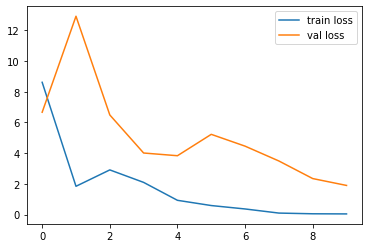

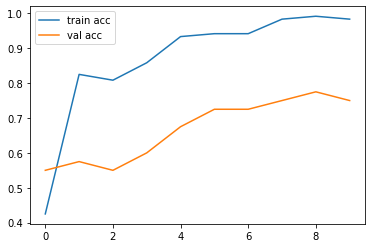

<Figure size 432x288 with 0 Axes>

In [33]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [34]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model.save('ricemodel_inception.h5')

In [50]:
import cv2
import itertools
import random
from collections import Counter
from glob import iglob

def load_image(filename):
    img = cv2.imread(os.path.join(valid_path, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img

def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {class_names[class_idx]: probabilities[class_idx]}

SOURCE: class: Bacterial Leaf Blight, file: Bacterial Leaf Blight/DSC_0702.jpg
PREDICTED: class: Leaf Smut, confidence: 0.734120


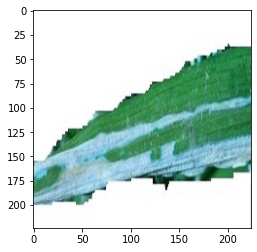

<Figure size 432x288 with 0 Axes>

SOURCE: class: BrownSpot, file: BrownSpot/DSC_0307.JPG
PREDICTED: class: Leaf Smut, confidence: 0.869313


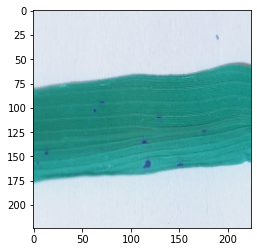

SOURCE: class: Healthy, file: Healthy/IMG_20190419_100703.jpg
PREDICTED: class: Healthy, confidence: 1.000000


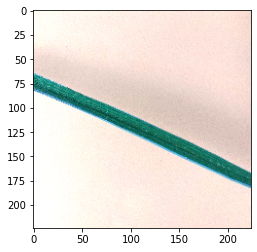

<Figure size 432x288 with 0 Axes>

SOURCE: class: Healthy, file: Healthy/IMG_20190419_100514.jpg
PREDICTED: class: Healthy, confidence: 1.000000


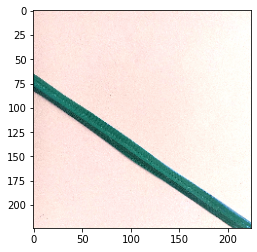

<Figure size 432x288 with 0 Axes>

SOURCE: class: Healthy, file: Healthy/IMG_20190419_100204.jpg
PREDICTED: class: Healthy, confidence: 1.000000


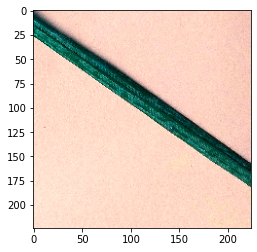

<Figure size 432x288 with 0 Axes>

In [51]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [39]:
y_pred = model.predict(validation_generator)

In [40]:
y_pred

array([[4.65352630e-27, 9.99999285e-01, 0.00000000e+00, 7.28634120e-07],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 3.05241904e-34],
       [3.01710516e-01, 1.61199010e-09, 4.45683556e-13, 6.98289454e-01],
       [1.00000000e+00, 1.14674692e-14, 8.10169303e-35, 5.46203075e-19],
       [7.26015344e-07, 9.99992132e-01, 4.47589344e-24, 7.12872179e-06],
       [6.74062585e-06, 9.99973655e-01, 2.01617504e-24, 1.96066248e-05],
       [3.83676861e-16, 7.42657781e-01, 4.13308510e-25, 2.57342160e-01],
       [5.90901903e-22, 1.37179632e-05, 2.20958652e-17, 9.99986291e-01],
       [1.11880760e-09, 2.34046951e-01, 6.55227164e-15, 7.65953004e-01],
       [1.10595195e-14, 9.99997854e-01, 3.47083884e-26, 2.15627801e-06],
       [8.40107083e-01, 1.59892216e-01, 3.45301118e-20, 7.07608990e-07],
       [9.03213222e-04, 6.11423016e-01, 4.68524762e-22, 3.87673706e-01],
       [0.00000000e+00, 8.64081869e-24, 1.00000000e+00, 1.71775202e-21],
       [0.00000000e+00, 1.27145499e-38, 1.00000000e

In [41]:
y_pred = np.argmax(y_pred, axis=1)

In [42]:
y_pred

array([1, 2, 3, 0, 1, 1, 1, 3, 3, 1, 0, 1, 2, 2, 1, 2, 2, 2, 1, 0, 0, 0,
       2, 1, 0, 1, 1, 1, 0, 1, 2, 0, 2, 3, 3, 2, 2, 3, 3, 0])